In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.datasets import fetch_x5

# Получение датасета

Задача: исследовать структуру данных и провести базовый feature-engeneering.

In [2]:
dataset = fetch_x5()

data = dataset.data

# Данные обо всех клиентах
clients = data.clients
# Клиенты для обучения
train = data.train           
# Информация о покупках
purchases = data.purchases

# Тритмент
treatement = dataset.treatment
# Целевая переменная
target = dataset.target

In [3]:
# Информация о клиентах
df_clients = pd.concat([train, treatement, target], axis=1)
df_clients = pd.merge(df_clients, clients, left_on='client_id', right_on='client_id')

In [4]:
df_clients.describe

<bound method NDFrame.describe of          client_id  treatment_flg  target     first_issue_date  \
0       000012768d              0       1  2017-08-05 15:40:48   
1       000036f903              1       1  2017-04-10 13:54:23   
2       00010925a5              1       1  2018-07-24 16:21:29   
3       0001f552b0              1       1  2017-06-30 19:20:38   
4       00020e7b18              1       1  2017-11-27 11:41:45   
...            ...            ...     ...                  ...   
200034  fffe0abb97              0       0  2017-11-27 08:56:54   
200035  fffe0ed719              0       1  2017-09-15 08:53:24   
200036  fffea1204c              0       1  2018-01-31 16:59:37   
200037  fffeca6d22              1       0  2017-12-28 11:56:13   
200038  fffff6ce77              0       1  2017-08-03 20:25:12   

          first_redeem_date  age gender  
0       2018-01-04 19:30:07   45      U  
1       2017-04-23 12:37:56   72      F  
2       2018-09-14 16:12:49   83      U  
3    

In [5]:
purchases.describe

<bound method NDFrame.describe of            client_id transaction_id transaction_datetime  \
0         000012768d     7e3e2e3984  2018-12-01 07:12:45   
1         000012768d     7e3e2e3984  2018-12-01 07:12:45   
2         000012768d     7e3e2e3984  2018-12-01 07:12:45   
3         000012768d     7e3e2e3984  2018-12-01 07:12:45   
4         000012768d     7e3e2e3984  2018-12-01 07:12:45   
...              ...            ...                  ...   
45786563  fffff6ce77     48f6d115ce  2019-03-15 17:47:02   
45786564  fffff6ce77     48f6d115ce  2019-03-15 17:47:02   
45786565  fffff6ce77     48f6d115ce  2019-03-15 17:47:02   
45786566  fffff6ce77     48f6d115ce  2019-03-15 17:47:02   
45786567  fffff6ce77     48f6d115ce  2019-03-15 17:47:02   

          regular_points_received  express_points_received  \
0                            10.0                      0.0   
1                            10.0                      0.0   
2                            10.0                      0.0 

In [6]:
df_clients.isna().sum()

client_id                0
treatment_flg            0
target                   0
first_issue_date         0
first_redeem_date    17546
age                      0
gender                   0
dtype: int64

In [7]:
purchases.isna().sum()

client_id                         0
transaction_id                    0
transaction_datetime              0
regular_points_received           0
express_points_received           0
regular_points_spent              0
express_points_spent              0
purchase_sum                      0
store_id                          0
product_id                        0
product_quantity                  0
trn_sum_from_iss                  0
trn_sum_from_red           42743212
dtype: int64

**Таблица clients: 200 039 строк.**

Колонки: `client_id`, `treatment_flg`, `target`, `first_issue_date`, `first_redeem_date`, `age`, `gender`.

• Объём данных — около 200 тыс клиентов, база для uplift-анализа.  
• `treatment_flg` и `target` — бинарные, пропусков нет, значит данные готовы к сравнению.  
• `first_issue_date` и `first_redeem_date` лежат в 2017–2018 годах - можно выделять когорты по кварталам.  
• Широкий диапазон возраста (примерно 18–90) — проверить выбросы.  
• Пол представлен M/F/U (неопределённый) — нужно учитывать U при интерпретации.  
• Разница между датой выпуска и первым использованием (лаг) отражает вовлечённость клиента.  

---

**Таблица purchases: ≈ 45,8 млн строк.**

Колонки: `client_id`, `transaction_i`, `transaction_datetime`, `regular_points_received`, `express_points_received`,   
`regular_points_spent`, `express_points_spent`, `purchase_sum`, `store_id`, `product_id`, `product_quantity`, `trn_sum_from_iss`, `trn_sum_from_red`.

• Очень крупная транзакционная база — около 230–250 покупок на клиента.  
• Повторяющиеся `product_id` в одной транзакции — необходима агрегация по `transaction_id`.  
• Поля с баллами часто равны нулю — начисления/списания нерегулярны.  
• `purchase_sum` имеет большой разброс — нужны квантили и стандартное отклонение.  
• На основе `store_id` можно строить метрики лояльности: разнообразие магазинов, доля посещений главного магазина.  

---

Что можно посмотреть в рамках анализа:

— поведенческие фичи: частота транзакций, средний чек, разнообразие товаров и магазинов;  
— доля операций с начислением и списанием баллов;  
— сезонность по месяцам, кварталам, дням недели и часам;  
— когортность по дате первой транзакции;  
— сравнение treatment/control по частоте, суммам и бонусным операциям.

# Предобработка данных и feature-engeneering

Пропуски есть только в `trn_sum_from_red`, что обозначает стоимость товара до применения баллов — равно `NaN` там, где человек не применил баллы.  
Можно восстановить по значению `trn_sum_from_iss` (стоимость товара после применения баллов).

In [8]:
purchases['trn_sum_from_red'] = purchases['trn_sum_from_red'].fillna(purchases['trn_sum_from_iss'])

In [9]:
# Преобразование значение потраченных баллов из отрицательных в положительные (для удобства сопоставления)
purchases['regular_points_spent'] = purchases['regular_points_spent'].abs()
purchases['express_points_spent'] = purchases['express_points_spent'].abs()

In [10]:
purchases.isna().sum()

client_id                  0
transaction_id             0
transaction_datetime       0
regular_points_received    0
express_points_received    0
regular_points_spent       0
express_points_spent       0
purchase_sum               0
store_id                   0
product_id                 0
product_quantity           0
trn_sum_from_iss           0
trn_sum_from_red           0
dtype: int64

**Распределение таргета:**

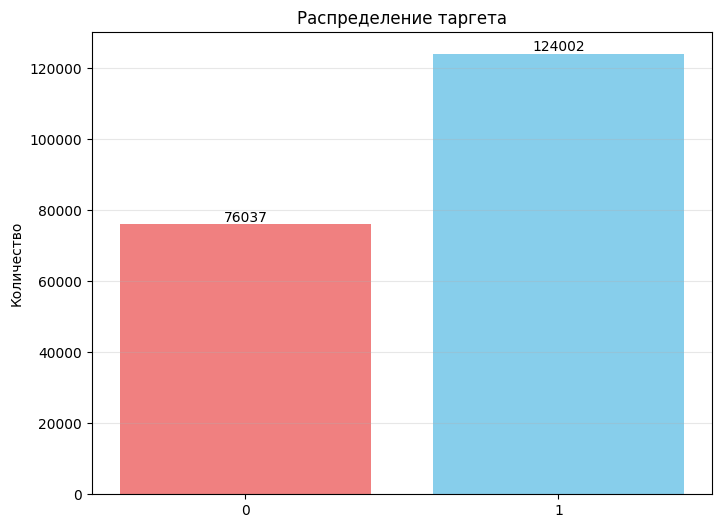

In [11]:
# Подсчет частот
value_counts = target.value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['lightcoral', 'skyblue'])
plt.ylabel('Количество')
plt.title('Распределение таргета')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', alpha=0.3)

# Добавление подписей:
for i, v in enumerate(value_counts.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

Количество данных почти в два раза больше для группы таргета.  
Необходимо опираться на корреляционный анализ и propensity-анализ для дисквалификации влияния признаков на таргет из-за смещенной выборки.

**Далее построим базовые признаки на основе транзакций, демографических, временных и продуктовых значений. Агрегируем исходные переменные.**

In [12]:
class BehavioralFeatureGenerator:
    """
    Класс-шаблон для генерации агрегированных поведенческих признаков.
    На основе транзакционных данных (таблица purchases).
    """
    def __init__(self, purchases_df):
        self.df = purchases_df.copy()

    # Уникальные транзакции (без дублирования по product_id)
    def _get_unique_transactions(self):
        cols_to_keep = ['client_id', 'transaction_id', 'transaction_datetime', 
                       'regular_points_received', 'express_points_received',
                       'regular_points_spent', 'express_points_spent', 
                       'purchase_sum', 'store_id']
        
        return self.df[cols_to_keep].drop_duplicates('transaction_id')

    # Данные на уровне продуктов
    def _get_product_level_data(self):
        product_cols = ['client_id', 'transaction_id', 'product_id', 
                       'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red']
        return self.df[product_cols]

    # Генерация всех фич
    def generate_features(self):
        features = {}
        
        # Базовые фичи по транзакциям
        features.update(self._transaction_features())
        
        # Фичи по баллам
        features.update(self._points_features())
        
        # Фичи по продуктам
        features.update(self._product_features())
        
        # Временные фичи
        features.update(self._time_features())
        
        # Фичи по магазинам
        features.update(self._store_features())
        
        return pd.DataFrame(features)

    # Фичи по транзакциям
    def _transaction_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        features = {
            'total_transactions': client_trans.size(),
            'total_purchase_sum': client_trans['purchase_sum'].sum(),
            'avg_transaction_amount': client_trans['purchase_sum'].mean(),
            'std_transaction_amount': client_trans['purchase_sum'].std(),
            'max_transaction_amount': client_trans['purchase_sum'].max(),
            'min_transaction_amount': client_trans['purchase_sum'].min(),
        }
        
        # Квантили
        for q in [0.25, 0.5, 0.75]:
            features[f'transaction_amount_q{q}'] = client_trans['purchase_sum'].quantile(q)
        
        return features

    # Фичи по баллам
    def _points_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        features = {
            'total_regular_points_received': client_trans['regular_points_received'].sum(),
            'total_express_points_received': client_trans['express_points_received'].sum(),
            'total_regular_points_spent': client_trans['regular_points_spent'].sum(),
            'total_express_points_spent': client_trans['express_points_spent'].sum(),
            'avg_regular_points_per_transaction': client_trans['regular_points_received'].mean(),
            'avg_express_points_per_transaction': client_trans['express_points_received'].mean(),
            'points_earned_to_spent_ratio': (client_trans['regular_points_received'].sum() + 
                                           client_trans['express_points_received'].sum()) / 
                                          (client_trans['regular_points_spent'].sum() + 
                                           client_trans['express_points_spent'].sum() + 1)  # +1 чтобы избежать деления на 0
        }
        
        return features

    # Фичи по продуктам
    def _product_features(self):
        product_df = self._get_product_level_data()
        client_products = product_df.groupby('client_id')
        features = {
            'total_products_purchased': client_products['product_quantity'].sum(),
            'unique_products_count': client_products['product_id'].nunique(),
            'total_trn_sum_from_iss': client_products['trn_sum_from_iss'].sum(),
            'total_trn_sum_from_red': client_products['trn_sum_from_red'].sum(),
            'avg_product_quantity': client_products['product_quantity'].mean(),
        }
        
        return features

    # Временные фичи
    def _time_features(self):
        trans_df = self._get_unique_transactions()
        trans_df['transaction_datetime'] = pd.to_datetime(trans_df['transaction_datetime'])
        client_trans = trans_df.groupby('client_id')
        first_date=client_trans['transaction_datetime'].min()
        last_date=client_trans['transaction_datetime'].max()
        features = {
            'first_transaction_date': first_date,
            'last_transaction_date': last_date,
            'transaction_period_days': (last_date - 
                                      first_date).dt.days,
        }
        
        features['transactions_per_day'] = (client_trans.size() / (features['transaction_period_days'] + 1))
        first_date_df = first_date.to_frame(name='first_date_tmp')

        # Квартал строим в формате год+Q+месяц, чтобы учесть "старость" клиентов
        first_date_df['first_transaction_quarter'] = (first_date_df['first_date_tmp'].dt.year.astype(str) 
                                                      + 'Q' + (((first_date_df['first_date_tmp'].dt.month - 1) // 3) + 1).astype(str))

        first_date_df['first_transaction_year_quarter_idx'] = (
             first_date_df['first_date_tmp'].dt.year * 4
             + ((first_date_df['first_date_tmp'].dt.month - 1) // 3 + 1)
             )

        features['first_transaction_quarter'] = first_date_df['first_transaction_quarter']
        features['first_transaction_year_quarter_idx'] = first_date_df['first_transaction_year_quarter_idx']
        
        # День недели и время суток
        trans_df['transaction_weekday'] = trans_df['transaction_datetime'].dt.dayofweek
        trans_df['transaction_hour'] = trans_df['transaction_datetime'].dt.hour
        
        # Самый частый день недели и час
        features['most_frequent_weekday'] = trans_df.groupby('client_id')['transaction_weekday'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        features['most_frequent_hour'] = trans_df.groupby('client_id')['transaction_hour'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
        )
        
        return features

    # Фичи по магазинам
    def _store_features(self):
        trans_df = self._get_unique_transactions()
        client_trans = trans_df.groupby('client_id')
        features = {
            'unique_stores_visited': client_trans['store_id'].nunique(),
            'most_frequent_store': client_trans['store_id'].agg(
                lambda x: x.mode()[0] if len(x.mode()) > 0 else -1
            ),
            'store_loyalty_ratio': client_trans['store_id'].agg(
                lambda x: x.value_counts().iloc[0] / len(x) if len(x) > 0 else 0
            )
        }
        
        return features


In [13]:
class StaticFeatureGenerator:
    """
    Шаблон класса для извлечения и генерации статических признаков.
    На основе данных о клиентах (таблица df_clients).
    """
    def __init__(self, clients_info_df):
        self.df = clients_info_df.copy()

    def generate_features(self):
        df_indexed = self.df.set_index('client_id')
        features = pd.DataFrame(index=df_indexed.index)

        first_issue = pd.to_datetime(df_indexed['first_issue_date'], errors='coerce')
        first_redeem = pd.to_datetime(df_indexed['first_redeem_date'], errors='coerce')

        # базовые календарные признаки
        features['first_issue_month'] = first_issue.dt.month
        features['first_issue_weekday'] = first_issue.dt.dayofweek

        # квартал и когорта (опять же, чтобы учесть "старость" клиентов, можно было давить и ранее, но выделим отдельно
        # так как это не транзакционная/поведенческая характеристика)
        features['first_issue_quarter'] = (first_issue.dt.year.astype(str)
            + 'Q'+ (((first_issue.dt.month - 1) // 3) + 1).astype(str))

        features['first_issue_year_quarter_idx'] = (
            first_issue.dt.year * 4
            + ((first_issue.dt.month - 1) // 3 + 1)
        )

        # лаг между выпуском карты и первым использованием
        features['redeem_lag_days'] = (first_redeem - first_issue).dt.days

        return features

In [14]:
# Генерация поведенческих фичей
behavioral_gen = BehavioralFeatureGenerator(purchases)
behavioral_features_df = behavioral_gen.generate_features()
print(f"Сгенерировано {behavioral_features_df.shape[1]} поведенческих признаков.")

Сгенерировано 32 поведенческих признаков.


In [15]:
# Генерация статических фичей
static_gen = StaticFeatureGenerator(df_clients)
static_features_df = static_gen.generate_features()
print(f"Сгенерировано {static_features_df.shape[1]} статических признаков.")

Сгенерировано 5 статических признаков.


In [16]:
# Объединение всех данных в один датафрейм с признаками
final_df_for_analysis = df_clients.set_index('client_id').join([static_features_df, behavioral_features_df])
print(f"\nРазмер итогового датафрейма для анализа: {final_df_for_analysis.shape}")


Размер итогового датафрейма для анализа: (200039, 43)


In [17]:
final_df_for_analysis.describe(include='all')

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,first_issue_month,first_issue_weekday,first_issue_quarter,first_issue_year_quarter_idx,...,last_transaction_date,transaction_period_days,transactions_per_day,first_transaction_quarter,first_transaction_year_quarter_idx,most_frequent_weekday,most_frequent_hour,unique_stores_visited,most_frequent_store,store_loyalty_ratio
count,200039.000000,200039.000000,200039,182493,200039.000000,200039,200039.000000,200039.000000,200039,200039.000000,...,200039,200039.000000,200039.000000,200039,200039.000000,200039.000000,200039.000000,200039.000000,200039,200039.000000
unique,NaN,NaN,199185,181971,NaN,3,NaN,NaN,8,NaN,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,13787,NaN
top,NaN,NaN,2017-09-29 16:18:02,2018-12-29 19:07:00,NaN,U,NaN,NaN,2017Q3,NaN,...,NaN,NaN,NaN,2018Q4,NaN,NaN,NaN,NaN,cfbbd53ab7,NaN
freq,NaN,NaN,3,3,NaN,92832,NaN,NaN,50726,NaN,...,NaN,NaN,NaN,169232,NaN,NaN,NaN,NaN,76,NaN
mean,0.499808,0.619889,NaN,NaN,46.417329,NaN,7.106979,2.944466,NaN,8072.591145,...,2019-03-12 16:26:45.063797760,90.949660,0.238139,NaN,8076.154005,2.641980,11.555862,2.920690,NaN,0.751867
min,0.000000,0.000000,NaN,NaN,-7491.000000,NaN,1.000000,0.000000,NaN,8070.000000,...,2019-02-24 21:27:32,0.000000,0.017544,NaN,8076.000000,0.000000,0.000000,1.000000,NaN,0.045455
25%,0.000000,0.000000,NaN,NaN,34.000000,NaN,5.000000,1.000000,NaN,8071.000000,...,2019-03-09 09:49:39,84.000000,0.105769,NaN,8076.000000,1.000000,9.000000,2.000000,NaN,0.571429
50%,0.000000,1.000000,NaN,NaN,45.000000,NaN,7.000000,3.000000,NaN,8072.000000,...,2019-03-14 13:50:21,102.000000,0.175926,NaN,8076.000000,3.000000,11.000000,2.000000,NaN,0.791667
75%,1.000000,1.000000,NaN,NaN,59.000000,NaN,10.000000,5.000000,NaN,8074.000000,...,2019-03-17 10:22:58,110.000000,0.288288,NaN,8076.000000,4.000000,15.000000,4.000000,NaN,0.989899
max,1.000000,1.000000,NaN,NaN,1852.000000,NaN,12.000000,6.000000,NaN,8077.000000,...,2019-03-18 23:19:28,116.000000,14.000000,NaN,8077.000000,6.000000,23.000000,95.000000,NaN,1.000000


In [18]:
# Проверка на случай пропусков
final_df_for_analysis.isna().sum()

treatment_flg                             0
target                                    0
first_issue_date                          0
first_redeem_date                     17546
age                                       0
gender                                    0
first_issue_month                         0
first_issue_weekday                       0
first_issue_quarter                       0
first_issue_year_quarter_idx              0
redeem_lag_days                       17546
total_transactions                        0
total_purchase_sum                        0
avg_transaction_amount                    0
std_transaction_amount                 3820
max_transaction_amount                    0
min_transaction_amount                    0
transaction_amount_q0.25                  0
transaction_amount_q0.5                   0
transaction_amount_q0.75                  0
total_regular_points_received             0
total_express_points_received             0
total_regular_points_spent      

• Предварительно, выборка сбалансирована: `treatment_flg` ≈ 0.5, `target` ≈ 0.62 — значит группы равные по распределению ключевых признаков и uplift можно исследовать.  
• Возраст содержит аномалии (минимум -7491, максимум 1852) — возраст нужно ограничить диапазонами, убрав аномальные значения (для EDA эти корректировки не критичны, для ликвидации выбросов возьмем среднее).  
• Пол часто неопределён (U ≈ половина клиентов) — как фича слабый показатель, но оставить можно как категориальный столбец, посмотрим его распределение и корреляции.  
• Из данных можно убрать показатели времени, поскольку мы их агрегировали в числовые и категориальные признаки.  
• Большинство клиентов получили карты в 2017Q3, а начали покупать в 2018Q4 — заметный лаг между выпуском и первой активностью.    
• Период активности клиентов короткий (медиана ~102 дня) — можно считать стаж и сезонность по кварталам.  
• Покупатели лояльны к магазинам (`store_loyalty_ratio` медиана 0.79) — чаще ходят в один и тот же магазин, как признак тем не менее потенциально полезен.  

Пропуски:  

`first_redeem_date` и `redeem_lag_days` — ~17,5k `NaN`, это "спящие" клиенты без активации,  
`std_transaction_amount` — ~3,8k `NaN` у клиентов с одной покупкой.

Так как их доля мала (<10%), эти признаки можно удалить из анализа, чтобы не вносить шум.  
Также мы можем обобщить информацию об активации и выпуске бонусных карт в бинарную меру, где 1 - активирована, 0 - не активирована.

In [19]:
# Определяем допустимый диапазон и средние возраста по квартилям
valid_mask = (final_df_for_analysis['age'] >= 15) & (final_df_for_analysis['age'] <= 100)
valid_ages = final_df_for_analysis.loc[valid_mask, 'age']

q1, q2, q3 = valid_ages.quantile([0.25, 0.5, 0.75])
mean_q1 = valid_ages[(valid_ages >= 15) & (valid_ages <= q1)].mean()
mean_q2 = valid_ages[(valid_ages > q1) & (valid_ages <= q2)].mean()
mean_q3 = valid_ages[(valid_ages > q2) & (valid_ages <= q3)].mean()
mean_q4 = valid_ages[(valid_ages > q3) & (valid_ages <= 100)].mean()

# Функция замены выбросов на средний возраст по квартилям
def replace_age_with_quartile_mean(age):
    if 15 <= age <= 100:
        return age
    if age < 15:
        return mean_q1
    elif 100 < age <= 200:
        return mean_q4
    else:
        # совсем большие выбросы вроде -7000 можно усреднить по всей выборке
        return valid_ages.mean()

final_df_for_analysis['age'] = final_df_for_analysis['age'].apply(replace_age_with_quartile_mean)

# Приводим пол к категориальному типу для последующего анализа
final_df_for_analysis['gender'] = final_df_for_analysis['gender'].astype('category')

# Бинарный флаг активации карты
final_df_for_analysis['is_activated'] = np.where(
    final_df_for_analysis['first_redeem_date'].notna(), 1, 0)

# Удаляем все признаки, связанные с датами и редкими NaN
cols_to_drop = [
    'first_issue_date',
    'first_redeem_date',
    'first_transaction_date',
    'last_transaction_date',
    'redeem_lag_days',
    'std_transaction_amount',
    'most_frequent_hour', # Слишком большой разброс
    'most_frequent_weekday', # Аналогично большой разброс, опираемся на месяные показатели
    'most_frequent_store' # Уникальных магазинов слишком много для категориальной переменной
    
]
final_df_for_analysis.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"Размер датафрейма после очистки: {final_df_for_analysis.shape}")
print("Удалены признаки:", cols_to_drop)
print("Добавлен признак: 'is_activated'")
print(f"Средние возраста по квартилям: Q1={mean_q1:.1f}, Q2={mean_q2:.1f}, Q3={mean_q3:.1f}, Q4={mean_q4:.1f}")

Размер датафрейма после очистки: (200039, 35)
Удалены признаки: ['first_issue_date', 'first_redeem_date', 'first_transaction_date', 'last_transaction_date', 'redeem_lag_days', 'std_transaction_amount', 'most_frequent_hour', 'most_frequent_weekday', 'most_frequent_store']
Добавлен признак: 'is_activated'
Средние возраста по квартилям: Q1=27.3, Q2=39.8, Q3=52.7, Q4=67.5


In [20]:
final_df_for_analysis.isna().sum()

treatment_flg                         0
target                                0
age                                   0
gender                                0
first_issue_month                     0
first_issue_weekday                   0
first_issue_quarter                   0
first_issue_year_quarter_idx          0
total_transactions                    0
total_purchase_sum                    0
avg_transaction_amount                0
max_transaction_amount                0
min_transaction_amount                0
transaction_amount_q0.25              0
transaction_amount_q0.5               0
transaction_amount_q0.75              0
total_regular_points_received         0
total_express_points_received         0
total_regular_points_spent            0
total_express_points_spent            0
avg_regular_points_per_transaction    0
avg_express_points_per_transaction    0
points_earned_to_spent_ratio          0
total_products_purchased              0
unique_products_count                 0


После очистки и агрегации можно расширить фичи так, чтобы они отражали ключевые аспекты поведения клиента в рознице — частоту, сумму, лояльность и типичные привычки покупок.  
Главная цель — получить интерпретируемые признаки без пропусков, которые несут реальную бизнес-логику для ритейла.

На основе нескольких итераций подготовки признаков и бизнес-логики определили следующие (с читаемыми наименованиями):

• `avg_purchase_per_day` — средняя сумма покупок в день активности (интенсивность расходов).  
• `spend_per_transaction` — отношение общей суммы к числу транзакций (средний чек).  
• `transactions_per_month` — среднее количество транзакций за месяц активности.  
• `points_earn_ratio` — доля транзакций, где начислялись бонусные баллы (частота вовлечённости в программу).  
• `points_spend_ratio` — доля транзакций со списанием баллов (активные пользователи программы).  
• `points_balance_ratio` — отношение всех полученных баллов к потраченным (также отражает активное использование программы лояльности).  
• `loyal_store_flag` — бинарный индикатор, сильно ли клиент лоялен одному магазину (если `store_loyalty_ratio` ≥ 0.9), де-факто агрегат для числового показателя.  
• `unique_store_intensity` — отношение числа посещённых магазинов к числу транзакций (разнообразие точек).  
• `activity_density` — отношение числа транзакций к длине активного периода (альтернатива `transactions_per_day`, без пропусков).  
• `avg_points_per_purchase` — среднее количество полученных баллов на 1 покупку.  
• `log_total_purchase_sum` — логарифм общей суммы покупок (устойчивый масштаб к выбросам — чтобы учесть требование сравнимости клиентов).  
• `seasonal_quarter_code` — числовой код сезона по кварталу первой транзакции (1 - зима, 2 - весна, 3 - лето, 4 - осень).  

In [21]:
# Деление без NaN, используем для удобства в дальнейшем
def safe_div(a, b):
    return np.where(b == 0, 0, a / b)

# 1. Средние чеки и интенсивность
final_df_for_analysis['avg_purchase_per_day'] = safe_div(
    final_df_for_analysis['total_purchase_sum'], 
    final_df_for_analysis['transaction_period_days'].clip(lower=1)
)

final_df_for_analysis['spend_per_transaction'] = safe_div(
    final_df_for_analysis['total_purchase_sum'],
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

final_df_for_analysis['transactions_per_month'] = safe_div(
    final_df_for_analysis['total_transactions'],
    (final_df_for_analysis['transaction_period_days'].clip(lower=1) / 30)
)

# 2. Работа с бонусами
final_df_for_analysis['points_earn_ratio'] = safe_div(
    final_df_for_analysis['total_regular_points_received'] + final_df_for_analysis['total_express_points_received'],
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

final_df_for_analysis['points_spend_ratio'] = safe_div(
    final_df_for_analysis['total_regular_points_spent'] + final_df_for_analysis['total_express_points_spent'],
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

final_df_for_analysis['points_balance_ratio'] = safe_div(
    (final_df_for_analysis['total_regular_points_received'] + final_df_for_analysis['total_express_points_received']),
    (final_df_for_analysis['total_regular_points_spent'] + final_df_for_analysis['total_express_points_spent'] + 1)
)

final_df_for_analysis['avg_points_per_purchase'] = safe_div(
    (final_df_for_analysis['total_regular_points_received'] + final_df_for_analysis['total_express_points_received']),
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

# 3. Поведение и лояльность
final_df_for_analysis['loyal_store_flag'] = np.where(
    final_df_for_analysis['store_loyalty_ratio'] >= 0.9, 1, 0
)

final_df_for_analysis['unique_store_intensity'] = safe_div(
    final_df_for_analysis['unique_stores_visited'],
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

final_df_for_analysis['activity_density'] = safe_div(
    final_df_for_analysis['total_transactions'],
    final_df_for_analysis['transaction_period_days'].clip(lower=1)
)

# 4. Масштаб и сезонность
final_df_for_analysis['log_total_purchase_sum'] = np.log1p(final_df_for_analysis['total_purchase_sum'])

# Преобразуем квартал в сезон (на основе first_transaction_year_quarter_idx)
def quarter_to_season(q_idx):
    if pd.isna(q_idx):
        return 0
    q = int(q_idx) % 4
    return {1: 1, 2: 2, 3: 3, 0: 4}[q]  # 1-зима, 2-весна, 3-лето, 4-осень

final_df_for_analysis['seasonal_quarter_code'] = final_df_for_analysis['first_transaction_year_quarter_idx'].apply(quarter_to_season)

# Проверим размер и отсутствие NaN
print(f"Добавлено новых признаков: {len(final_df_for_analysis.columns)} колонок в итоге.")
print("NaN после добавления:", final_df_for_analysis.isna().sum().sum())

Добавлено новых признаков: 47 колонок в итоге.
NaN после добавления: 0


# Корреляционный анализ признаков

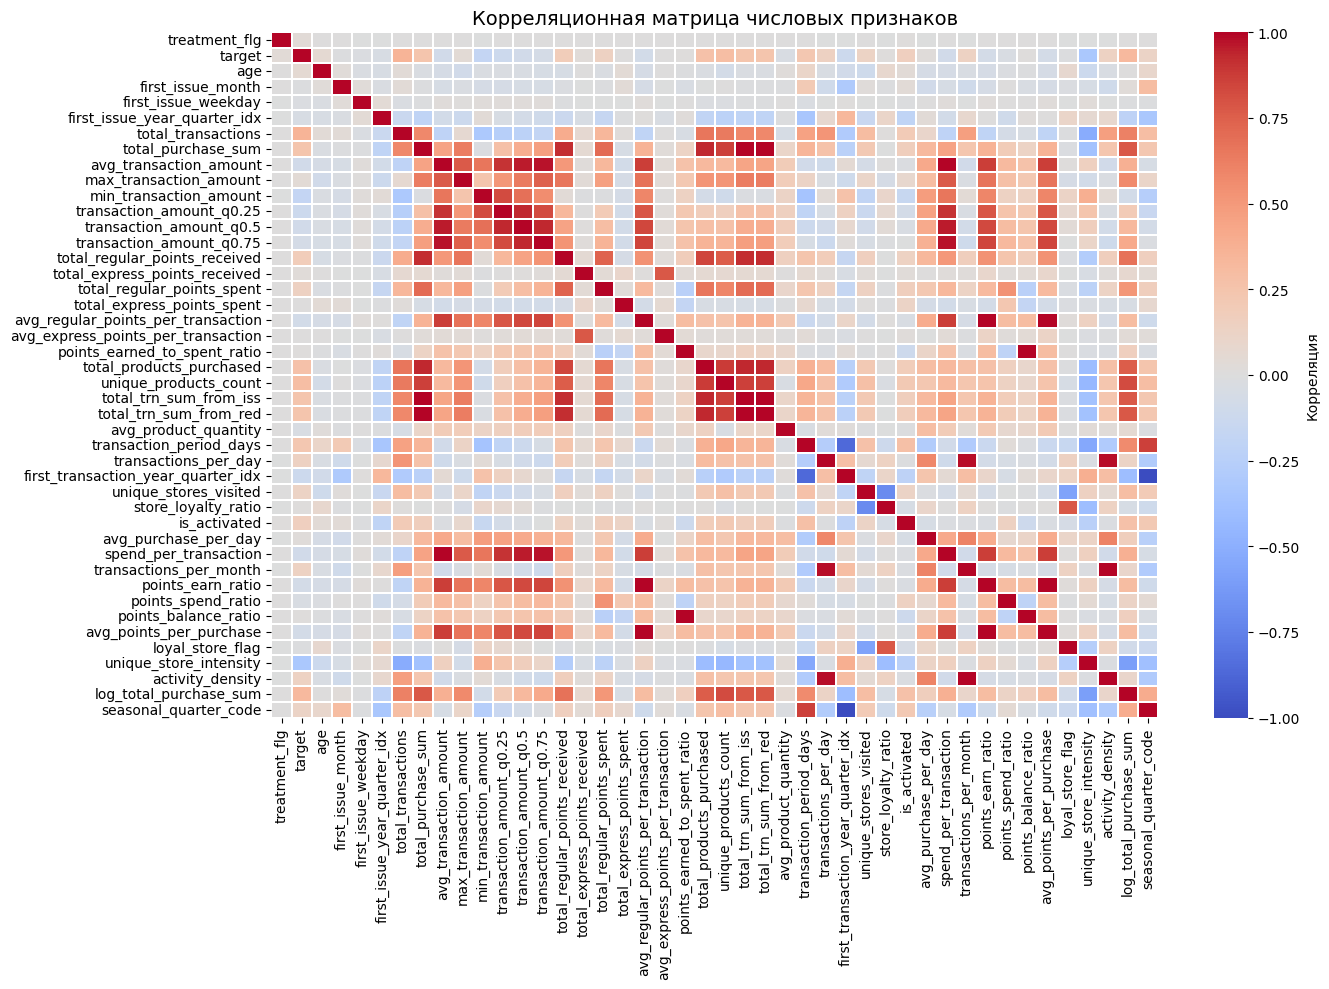

Всего сильно коррелирующих пар (|corr| > 0.7): 64


,feature_1,feature_2,corr
907,transactions_per_month,activity_density,1.000000
912,points_earn_ratio,avg_points_per_purchase,1.000000
686,points_earned_to_spent_ratio,points_balance_ratio,1.000000
340,avg_transaction_amount,spend_per_transaction,1.000000
736,total_trn_sum_from_iss,total_trn_sum_from_red,0.999937
296,total_purchase_sum,total_trn_sum_from_red,0.998121
295,total_purchase_sum,total_trn_sum_from_iss,0.998064
637,avg_regular_points_per_transaction,points_earn_ratio,0.994980
640,avg_regular_points_per_transaction,avg_points_per_purchase,0.994980
823,transactions_per_day,activity_density,0.978124


In [22]:
# Что бы вывести все пары с высокой корреляцией независимо от их количества, в противном случае на аутпуте покажет неполный список
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

numeric_df = final_df_for_analysis.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    cbar_kws={'label': 'Корреляция'}
)
plt.title('Корреляционная матрица числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr'})
    .sort_values('corr', ascending=False)
)

high_corr_pairs = high_corr_pairs[high_corr_pairs['corr'].abs() > 0.7]

print(f"Всего сильно коррелирующих пар (|corr| > 0.7): {len(high_corr_pairs)}")
display(high_corr_pairs)

Корреляции выше 0.7 группируются в логические кластеры признаков (брали пороговые 0.7 как стандарт).  
Это означает, что многие фичи дублируют друг друга по смыслу (частота покупок, чеки, бонусы и т.д.), а не несут новую информацию.  
Чтобы модель не страдала от мультиколлинеарности, мы оставляем внутри каждого такого кластера один признак, который интерпретируется проще всего.  
Ближе к подготовке первых моделей решим мультиколлинеарность непосредственно через регрессионный анализ, на текущем разведочном этапе необхоидмости нет.  

---

Что мы считаем избыточным:

- `activity_density`, `transactions_per_day` — частотные метрики. Оставляем `transactions_per_month` как основную частоту покупок клиента, поскольку это более интерпретируемый признак.
- `spend_per_transaction`, `transaction_amount_q0.25`, `transaction_amount_q0.5`, `transaction_amount_q0.75` — метрики чека. Оставляем `avg_transaction_amount` как средний чек.
- `total_trn_sum_from_red`, `total_trn_sum_from_iss`, `total_purchase_sum` — это всё одно и то же про общий объём трат. Для модели оставляем сглаженный вариант `log_total_purchase_sum`.  
- `avg_regular_points_per_transaction`, `points_earn_ratio`, `avg_points_per_purchase` — это варианты того, как клиент использует бонусную программу. Оставляем более общую метрику.  
- `total_regular_points_received`, `total_regular_points_spent` — абсолютные суммы баллов сильно связаны с общим объёмом покупок, не дают дополнительную информацию.  
- `total_products_purchased` очень сильно коррелирует с `unique_products_count`. Оставляем `unique_products_count` как показатель разнообразия корзины.  
- `loyal_store_flag` — это бинарная форма `store_loyalty_ratio`, как мы указывали выше. Оставляем бинарное значение, ниже переопределим признак.  
- `first_transaction_year_quarter_idx` — это индекс квартала, у нас уже есть `seasonal_quarter_code`, который более интерпретируемый

Что дополнительно добавляем как бизнес-показатели:

- `avg_items_per_transaction` = среднее число товаров на одну транзакцию. Отличает человека со стабильной корзиной, от оптового закупщика или крупнобюджетных потребителей. 
- `spend_points_per_transaction` = сколько бонусных баллов в среднем списывается за транзакцию. Это прямой показатель вовлечённости в программу лояльности (реальное использует или нет).  
- `store_visit_intensity` = отношение количества уникальных магазинов к количеству транзакций. Показывает разнообразие клиента относительно выбора места покупки. 
- `transaction_value_density` = логарифм общей суммы покупок, нормированный на длительность активного периода. Показывает, насколько клиент "дорогой в единицу времени", а не просто "много купил за все время".  
- `is_super_loyal` = бинарный флаг (1 если ≥90% транзакций в одном магазине). Лояльность к месту.

In [23]:
def safe_div(a, b):
    return np.where(b == 0, 0, a / b)

basket_numerator = final_df_for_analysis['total_products_purchased']

final_df_for_analysis['avg_items_per_transaction'] = safe_div(
    basket_numerator,
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

spent_points = 0
spent_points = spent_points + final_df_for_analysis['total_regular_points_spent']

final_df_for_analysis['spend_points_per_transaction'] = safe_div(
    spent_points,
    final_df_for_analysis['total_transactions'].clip(lower=1)
)
final_df_for_analysis['store_visit_intensity'] = safe_div(
    final_df_for_analysis['unique_stores_visited'],
    final_df_for_analysis['total_transactions'].clip(lower=1)
)

final_df_for_analysis['transaction_value_density'] = safe_div(
    final_df_for_analysis['log_total_purchase_sum'],
    final_df_for_analysis['transaction_period_days'].clip(lower=1)
)

final_df_for_analysis['is_super_loyal'] = np.where(
    final_df_for_analysis['store_loyalty_ratio'] >= 0.9,
    1,
    0
)

cols_to_drop_after_enrichment = [
    'activity_density',
    'transactions_per_day',
    'spend_per_transaction',
    'transaction_amount_q0.25',
    'transaction_amount_q0.5',
    'transaction_amount_q0.75',
    'total_purchase_sum',
    'total_trn_sum_from_red',
    'total_trn_sum_from_iss',
    'avg_regular_points_per_transaction',
    'points_earn_ratio',
    'avg_points_per_purchase',
    'total_regular_points_received',
    'total_regular_points_spent',
    'total_products_purchased',
    'loyal_store_flag',
    'first_transaction_year_quarter_idx'
]

final_df_for_analysis.drop(
    columns=cols_to_drop_after_enrichment,
    inplace=True,
    errors='ignore'
)


print("Финальное число колонок:", len(final_df_for_analysis.columns))
print("Итоговый набор колонок:")
print(final_df_for_analysis.columns)

Финальное число колонок: 35
Итоговый набор колонок:
Index(['treatment_flg', 'target', 'age', 'gender', 'first_issue_month', 'first_issue_weekday', 'first_issue_quarter', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_quarter', 'unique_stores_visited', 'store_loyalty_ratio', 'is_activated', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'store_visit_intensity', 'transaction_value_density', 'is_super_loyal'], dtype='object')


In [24]:
final_df_for_analysis.isna().sum().sum()

np.int64(0)

**Теперь посмотрим на корреляции категориальных признаков**

In [25]:
from scipy.stats import chi2_contingency
import itertools

Категориальные признаки для анализа:
['treatment_flg', 'target', 'gender', 'first_issue_quarter', 'first_transaction_quarter', 'is_activated', 'is_super_loyal']


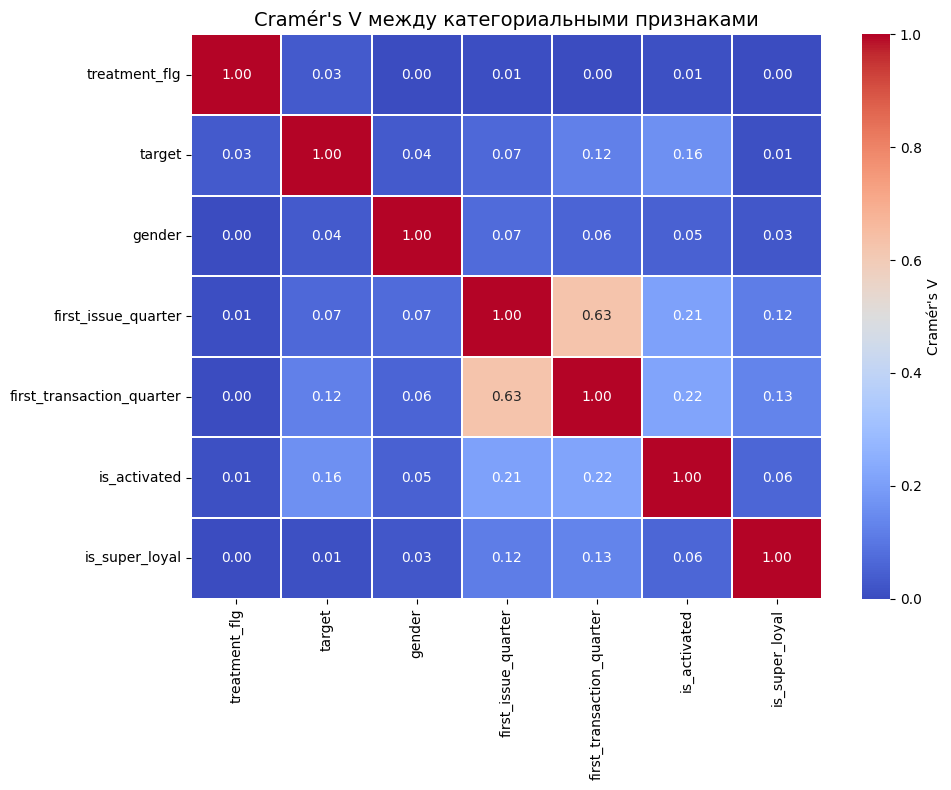

Все пары категориальных признаков и их связь (Cramér's V):


,feature_1,feature_2,v_cramer
0,first_issue_quarter,first_transaction_quarter,0.625281
1,first_transaction_quarter,is_activated,0.218487
2,first_issue_quarter,is_activated,0.208523
3,target,is_activated,0.163434
4,first_transaction_quarter,is_super_loyal,0.129689
5,target,first_transaction_quarter,0.121179
6,first_issue_quarter,is_super_loyal,0.115085
7,gender,first_issue_quarter,0.072764
8,target,first_issue_quarter,0.065541
9,is_activated,is_super_loyal,0.061662


In [26]:
categorical_features = []
for col in final_df_for_analysis.columns:
    s = final_df_for_analysis[col]
    if s.dtype.name in ['object', 'category']:
        categorical_features.append(col)
        continue

    # бинарные флаги считаем категориальными
    if s.dtype.kind in ['i', 'u', 'f']:
        uniq_vals = pd.unique(s.dropna())
        if len(uniq_vals) <= 2 and set(uniq_vals).issubset({0, 1}):
            categorical_features.append(col)

# убираем дубликаты, если есть
categorical_features = list(dict.fromkeys(categorical_features))
print("Категориальные признаки для анализа:")
print(categorical_features)

def cramers_v(x, y):
    ctab = pd.crosstab(x, y)
    if ctab.size == 0:
        return np.nan
    chi2 = chi2_contingency(ctab, correction=False)[0]
    n = ctab.to_numpy().sum()
    phi2 = chi2 / n
    r, k = ctab.shape
    # коррекция Беггена - из-за того, что категориальные признаки имеют разное кол-во категорий, решает переоценку силы связи
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)

    denom = min((k_corr - 1), (r_corr - 1))
    if denom <= 0: # если коэффициент с одним наблюдением, то тогда знаменатель на формуле коррекции будет ошибкой
        return np.nan

    return np.sqrt(phi2_corr / denom)

cramers_matrix = pd.DataFrame(
    index=categorical_features,
    columns=categorical_features,
    dtype=float
)
for c1, c2 in itertools.combinations_with_replacement(categorical_features, 2):
    v_val = cramers_v(final_df_for_analysis[c1], final_df_for_analysis[c2])
    cramers_matrix.loc[c1, c2] = v_val
    cramers_matrix.loc[c2, c1] = v_val

plt.figure(figsize=(10, 8))
sns.heatmap(
    cramers_matrix.astype(float),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    linewidths=0.3,
    cbar_kws={'label': "Cramér's V"}
)
plt.title("Cramér's V между категориальными признаками", fontsize=14)
plt.tight_layout()
plt.show()

pairs_df = (
    cramers_matrix.where(np.triu(np.ones(cramers_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={
        "level_0": "feature_1",
        "level_1": "feature_2",
        0: "v_cramer"
    })
    .sort_values("v_cramer", ascending=False)
    .reset_index(drop=True)
)

print("Все пары категориальных признаков и их связь (Cramér's V):")
display(pairs_df)

Категориальные связи оценены с помощью двух показателей:

- χ² (хи-квадрат) — базовая мера различия между *наблюдаемыми* и *ожидаемыми* частотами в таблице сопряженности признаков.  
Чем больше χ², тем сильнее расхождение и тем больше зависимость между признаками.  
Проблема: χ² зависит от размера выборки — при большом n даже слабая связь может давать значимое χ².  

- Коэффициент Крамера V (с корректировкой) — нормализованная версия χ², где V = √( χ² / (n × (min(k, r) − 1)) ).  
  Диапазон от 0 до 1:  
  • 0 = полная независимость,  
  • 1 = один признак определяет другой.  
  Коррекция убирает смещение на больших n и делает V сравнимым между таблицами разных размеров.

---

Интерпретация результатов:

- Самая сильная зависимость — `first_issue_quarter` + `first_transaction_quarter` (V ≈ 0.63).  
Квартал выпуска карты сильно связан с кварталом первой транзакции. Они фактически измеряют одно и то же событие во времени.  
Оставляем только `first_transaction_quarter` как меру активности покупателя.

- Все остальные связи имеют V < 0.3 — слабые.  
`is_activated`, `treatment_flg`, `target`, `is_super_loyal`, `gender` — де-факто независимы.  
Они несут самостоятельный смысл, поэтому оставляем их.

In [27]:
final_df_for_analysis.drop(columns=['first_issue_quarter'], inplace=True)
print("Удалён категориальный дубликат: first_issue_quarter")

Удалён категориальный дубликат: first_issue_quarter


# Распределение таргета по признакам и группам тритмента

In [28]:
from pandas.api import types as ptypes
from sklearn.metrics import roc_auc_score, matthews_corrcoef

**Метрики силы связи признаков с целевой переменной:**

*Pearson r / phi*

Измеряет степень линейной (для числовых) или бинарной (для булевых) корреляции между признаком и целевой переменной. Значения лежат в диапазоне от –1 до 1.  
Чем ближе модуль значения к 1, тем сильнее линейная зависимость. Для бинарных признаков используется φ-коэффициент — аналог корреляции для таблицы сопряжённости.

*SMD (Standardized Mean Difference)*

Показывает разницу средних значений признака между двумя группами (таргет = 0 и таргет = 1), нормированную на среднее стандартное отклонение.  
Характеризует размер эффекта: насколько сильно различаются распределения признака в разных классах. Чем выше по модулю значение, тем сильнее эффект.

*AUC (Area Under the ROC Curve)*

Измеряет, насколько хорошо признак способен различать классы. Значение 0.5 соответствует случайному различению, 1.0 — идеальному разделению, меньше 0.5 — противоположное разделение.   
Удобна для оценки бинарных эффектов.

*Eta-squared (η²)*

Характеризует долю дисперсии целевой переменной, объясняемую категориальным признаком. Это аналог R² из регрессии, но применимый для категориальных факторов.   
Чем ближе к 1, тем сильнее категория влияет на целевую переменную (+ показатель распределения).

*Combined (сводный скор)*

Метрика, объединяющая нормированные значения всех показателей. Позволяет быстро сравнивать признаки между собой по общей "силе связи" с целевой переменной на шкале от 0 до 1.

---

Используем для многосторонней оценки распределения признаков по таргету.

In [29]:
# 1) Подсчёт метрик
def feature_summary(df: pd.DataFrame, target: str, min_cat_freq: float = 0.005) -> pd.DataFrame:
    """
    Коротко:
      - numeric: Pearson, SMD, AUC
      - binary:  phi, SMD, AUC
      - categ:   eta^2 (через межгрупповую дисперсию), AUC
    df предочищен от пропусков. 
    """
    y = pd.to_numeric(df[target]).astype(int)
    out = []
    # Делим типы
    for col in (c for c in df.columns if c != target):
        s = df[col]
        if ptypes.is_bool_dtype(s) or (ptypes.is_numeric_dtype(s) and s.dropna().astype(float).nunique() <= 2 and set(s.dropna().astype(float)) <= {0.0, 1.0}):
            kind = "binary"
        elif ptypes.is_numeric_dtype(s):
            kind = "numeric"
        else:
            kind = "categorical"


        if kind == "numeric":
            x = pd.to_numeric(s).astype(float)
            r   = float(pd.Series(x).corr(y))
            # SMD
            x0, x1 = x[y == 0], x[y == 1]
            pooled = np.sqrt((x0.var(ddof=1) + x1.var(ddof=1)) / 2)
            smd = float((x1.mean() - x0.mean()) / pooled) if pooled > 0 else np.nan
            auc = float(roc_auc_score(y, x))
            eta2 = np.nan
            sign = r

        elif kind == "binary":
            xb = pd.to_numeric(s).astype(int)
            r   = float(matthews_corrcoef(y, xb))
            x0, x1 = xb[y == 0], xb[y == 1]
            pooled = np.sqrt((x0.var(ddof=1) + x1.var(ddof=1)) / 2)
            smd = float((x1.mean() - x0.mean()) / pooled) if pooled > 0 else np.nan
            auc = float(roc_auc_score(y, xb))
            eta2 = np.nan
            sign = r

        else:
            # редкие категории схлопываем (если есть)
            vc = s.value_counts(normalize=True)
            x = s.where(~s.isin(vc[vc < min_cat_freq].index), "RARE").astype(str)
            # eta^2: SS_between / SS_total
            mu  = y.mean()
            means = y.groupby(x).mean()
            counts = x.value_counts().reindex(means.index)
            ss_between = ((means - mu) ** 2 * counts).sum()
            ss_total   = ((y - mu) ** 2).sum()
            eta2 = float(ss_between / ss_total) if ss_total > 0 else np.nan
            # AUC
            tr = y.groupby(x).mean()
            score = x.map(tr).astype(float)
            auc = float(roc_auc_score(y, score))
            r = np.nan
            smd = np.nan
            sign = np.nan

        # нормировки 0-1
        corr = abs(r) if np.isfinite(r) else (eta2 if np.isfinite(eta2) else np.nan)
        auc_n = abs(auc - 0.5) * 2.0 if np.isfinite(auc) else np.nan
        smd_n = min(abs(smd) / 0.8, 1.0) if np.isfinite(smd) else np.nan
        parts = [p for p in (corr, auc_n, smd_n) if np.isfinite(p)]
        combined = float(np.mean(parts)) if parts else np.nan
        out.append(dict(
            feature=col, kind=kind,
            score=corr, sign=sign,
            auc=auc, auc_norm=auc_n,
            smd=smd, smd_norm=smd_n,
            eta2=eta2, combined=combined
        ))

    return (pd.DataFrame(out)
            .sort_values("combined", ascending=False, na_position="last")
            .reset_index(drop=True))

# 2) Графики
def plot_ranked(summary: pd.DataFrame, by: str = "combined", top_k: int = 25, title: str | None = None):
    sub = summary.sort_values(by, ascending=False).head(top_k).iloc[::-1]
    colors = sub["kind"].map({"numeric": "#5B8FF9", "binary": "#5AD8A6", "categorical": "#F6BD16"}).fillna("#BFBFBF")
    plt.figure(figsize=(10, max(4, 0.4 * len(sub))))
    plt.barh(sub["feature"], sub[by], color=colors)
    if by in {"score", "auc_norm", "smd_norm", "combined"}:
        plt.xlim(0, 1)

    # Подписи чисел у столбцов
    for y, v in enumerate(sub[by].values):
        if np.isfinite(v):
            plt.text(v + 0.01, y, f"{v:.3f}", va="center", fontsize=9)

    plt.title(title or f"Топ-{len(sub)} по {by}")
    plt.xlabel(by)
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


def plot_bubble(summary: pd.DataFrame, title: str = "AUC vs SMD (норм.) — подписи всех признаков"):
    sub = summary.copy()
    sub["auc_norm"] = sub["auc_norm"].fillna(0.0)
    sub["smd_norm"] = sub["smd_norm"].fillna(0.0)
    colors = sub["kind"].map({"numeric": "#5B8FF9", "binary": "#5AD8A6", "categorical": "#F6BD16"}).fillna("#BFBFBF")

    # фиксированный размер для пузырьков (чтобы минимальные было все равно видно)
    size = 160

    plt.figure(figsize=(11, 7))
    plt.scatter(sub["auc_norm"], sub["smd_norm"], s=size, c=colors, alpha=0.85, edgecolor="white", linewidth=0.6)

    # подписи для всех точек
    for _, r in sub.iterrows():
        plt.text(r["auc_norm"] + 0.01, r["smd_norm"] + 0.01, str(r["feature"]), fontsize=9)

    plt.xlabel("|AUC - 0.5| × 2")
    plt.ylabel("|SMD| / 0.8")
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    plt.grid(alpha=0.3, linewidth=0.6)
    plt.title(title)
    plt.tight_layout()
    plt.show()

Методом проб и ошибок мы определили, что в данных могут быть np.inf значения (стремящиеся к бесконечности).  
В числовых признаках они появляются из-за арифметических операций, где знаменатель 0 или логарифм аргумента ≤ 0:

Что делаем:

- Вместо NaN-ов мы заменяем ±inf на потолочные конечные числа.  
- Обрезаем числовые колонки до заданного диапазона (например, ±1e9), чтобы не было бесконечностей и переполнений. Сильной потери информации срезы не несут.

In [30]:
for col in final_df_for_analysis.select_dtypes(include=[np.number]).columns:
    s = final_df_for_analysis[col]
    s = s.replace(np.inf, 1e9).replace(-np.inf, -1e9)
    s = np.clip(s, -1e9, 1e9)
    final_df_for_analysis[col] = s.round(6)

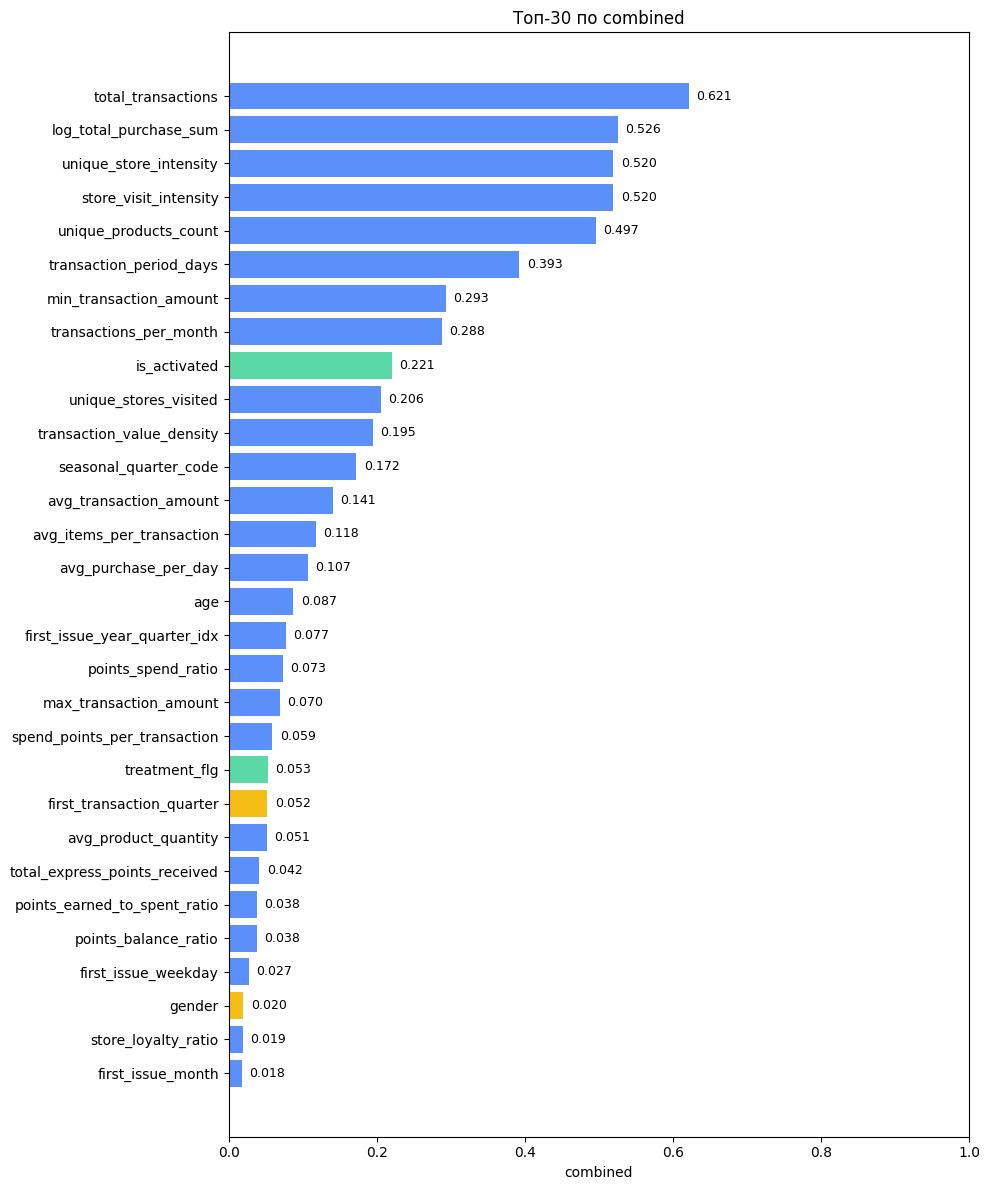

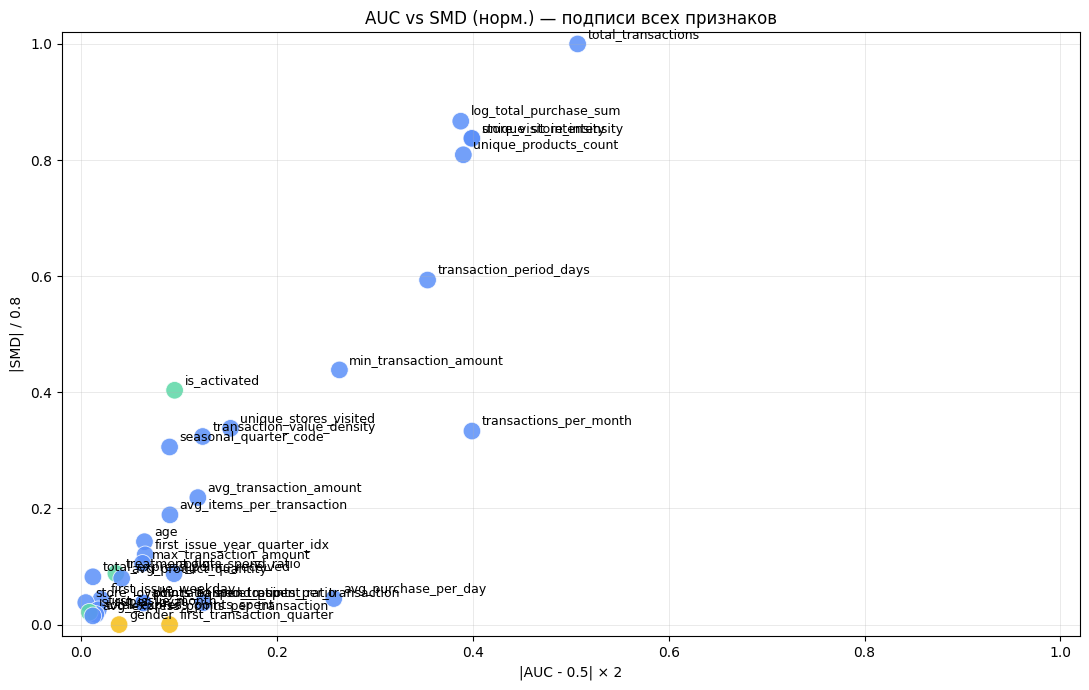

In [31]:
TARGET = "target"
summary = feature_summary(final_df_for_analysis, target=TARGET)

plot_ranked(summary, by="combined", top_k=30)
plot_bubble(summary)



In [32]:
display(summary)

,feature,kind,score,sign,auc,auc_norm,smd,smd_norm,eta2,combined
0,total_transactions,numeric,0.356609,0.356609,0.753445,0.506890,0.836036,1.000000,NaN,0.621166
1,log_total_purchase_sum,numeric,0.323972,0.323972,0.693762,0.387524,0.693592,0.866990,NaN,0.526162
2,unique_store_intensity,numeric,0.323190,-0.323190,0.300582,0.398835,-0.669938,0.837422,NaN,0.519816
3,store_visit_intensity,numeric,0.323190,-0.323190,0.300582,0.398835,-0.669938,0.837422,NaN,0.519816
4,unique_products_count,numeric,0.290271,0.290271,0.695076,0.390153,0.647297,0.809121,NaN,0.496515
5,transaction_period_days,numeric,0.230674,0.230674,0.676821,0.353642,0.474709,0.593386,NaN,0.392567
6,min_transaction_amount,numeric,0.178185,-0.178185,0.368203,0.263594,-0.350899,0.438623,NaN,0.293468
7,transactions_per_month,numeric,0.133133,0.133133,0.699474,0.398949,0.266666,0.333332,NaN,0.288471
8,is_activated,binary,0.163448,0.163448,0.547625,0.095250,0.322858,0.403573,NaN,0.220757
9,unique_stores_visited,numeric,0.127131,0.127131,0.576172,0.152343,0.270446,0.338058,NaN,0.205844


Интерпретация:

1–5: Метрики частоты и объёма покупок — база клиентской активности:  
`total_transactions`, `log_total_purchase_sum`, `unique_store_intensity`, `store_visit_intensity`, `unique_products_count	`, `transaction_period_days`.   

Эти признаки имеют максимальные combined (0.39–0.62), что показывает:  

- если клиент в среднем покупает большие объемы продукта (возможно, чаще посещает магазин), вероятность целевого действия;
- клиенты, привязанные к местности, имеют больший шанс воспользоваться промо;
- эффект выражен и по корреляции, и по SMD;  
- AUC ≈ 0.68–0.75 показывает, что этих фич достаточно для разделения клиентов на активных и спящих.   

Для uplift-модели признаки отражают активность клиента на уровне потребления.

---

6–11: Частота покупок и регулярные клиенты:   
`min_transaction_amount`, `transactions_per_month`, `is_activated`, `unique_stores_visited`, `transaction_value_density`, `seasonal_quarter_code`.             

Умеренная связь (combined ≈ 0.17–0.29):  

- клиенты, чаще потребляющие товар у ритейлера, чаще совершают целевое действие  
- AUC > 0.5 в среднем подтверждает, что общая активность отделяет вовлечённых клиентов от остальных.  

В uplift-контексте эти признаки нужны, чтобы модель понимала, как регулярность потребления отделяет потенциально таргетируемых клиентов от бесполезных.

---

12–24: Уровень потребления клиентов:
`avg_transaction_amount`, `avg_items_per_transaction`, `avg_purchase_per_day`, `age`, `first_issue_year_quarter_idx`, `points_spend_ratio`,    
`max_transaction_amount`, `spend_points_per_transaction`, `first_transaction_quarter`, `avg_product_quantity`, `total_express_points_received`, `points_earned_to_spent_ratio`.     

Слабая (combined ~0.04–0.14), но отражают категории потребителей по уровню и стоимости покупок:  

- часто встречаемый отрицательный знак показывает, что категории клиентов премиального уровня (крупнобюджетные) не реагируют (а то и негативны) на промо;    
- по признакам можно выделить самодостаточных клиентов, которые не сжаты рамками бюджетирования покупок у ритейлера;   
- возраст также может являться мерой отсечения таких клиентов.  

Для uplift-анализа это показатели, которые определяют клиентов, которых лучше не беспокоить.

---

25–32: Бонусная программа:

`points_balance_ratio`, `first_issue_weekday`, `gender`, `store_loyalty_ratio`, `first_issue_month`, `total_express_points_spent`,    
`is_super_loyal`, `avg_express_points_per_transaction`.       

Очень слабая связь (combined ~0.01–0.26), отражает неактивных и спонтанных клиентов.  
Скорее всего, клиенты со спонтанными покупками (большие траты экспресс-баллов), менее подвержены влиянию промо.    
Также гендер может в совокупности определять воздействие, но как отдельный признак не дает информации.

В uplift эти показатели стоит рассматривать как дополнительные или как меру того, насколько полезным окажется контакт через промо.

**Теперь посмотрим на распределение в группах по тритменту:**

Наиболее усилившиеся признаки (treatment=1 выше):


,feature,kind,combined_t0,combined_t1,delta
0,age,numeric,0.064108,0.111468,0.047360
1,total_express_points_spent,numeric,0.015288,0.040865,0.025577
2,avg_items_per_transaction,numeric,0.105784,0.131049,0.025265
3,avg_transaction_amount,numeric,0.130144,0.153124,0.022981
4,is_activated,binary,0.210729,0.230549,0.019820
5,first_issue_month,numeric,0.012887,0.022942,0.010055
6,gender,categorical,0.016622,0.023267,0.006645
7,store_loyalty_ratio,numeric,0.017584,0.020736,0.003152
8,transactions_per_month,numeric,0.287898,0.289901,0.002004
9,points_balance_ratio,numeric,0.037255,0.039237,0.001982


Наиболее ослабленные признаки (treatment=1 ниже):


,feature,kind,combined_t0,combined_t1,delta
23,total_transactions,numeric,0.626520,0.616066,-0.010454
24,seasonal_quarter_code,numeric,0.177833,0.166865,-0.010968
25,avg_product_quantity,numeric,0.059282,0.047121,-0.012162
26,transaction_period_days,numeric,0.398824,0.386564,-0.012260
27,avg_purchase_per_day,numeric,0.115545,0.099506,-0.016039
28,unique_stores_visited,numeric,0.214395,0.197307,-0.017088
29,first_issue_year_quarter_idx,numeric,0.090421,0.063483,-0.026938
30,max_transaction_amount,numeric,0.084000,0.054535,-0.029465
31,unique_products_count,numeric,0.513314,0.479855,-0.033459
32,log_total_purchase_sum,numeric,0.547789,0.504792,-0.042997


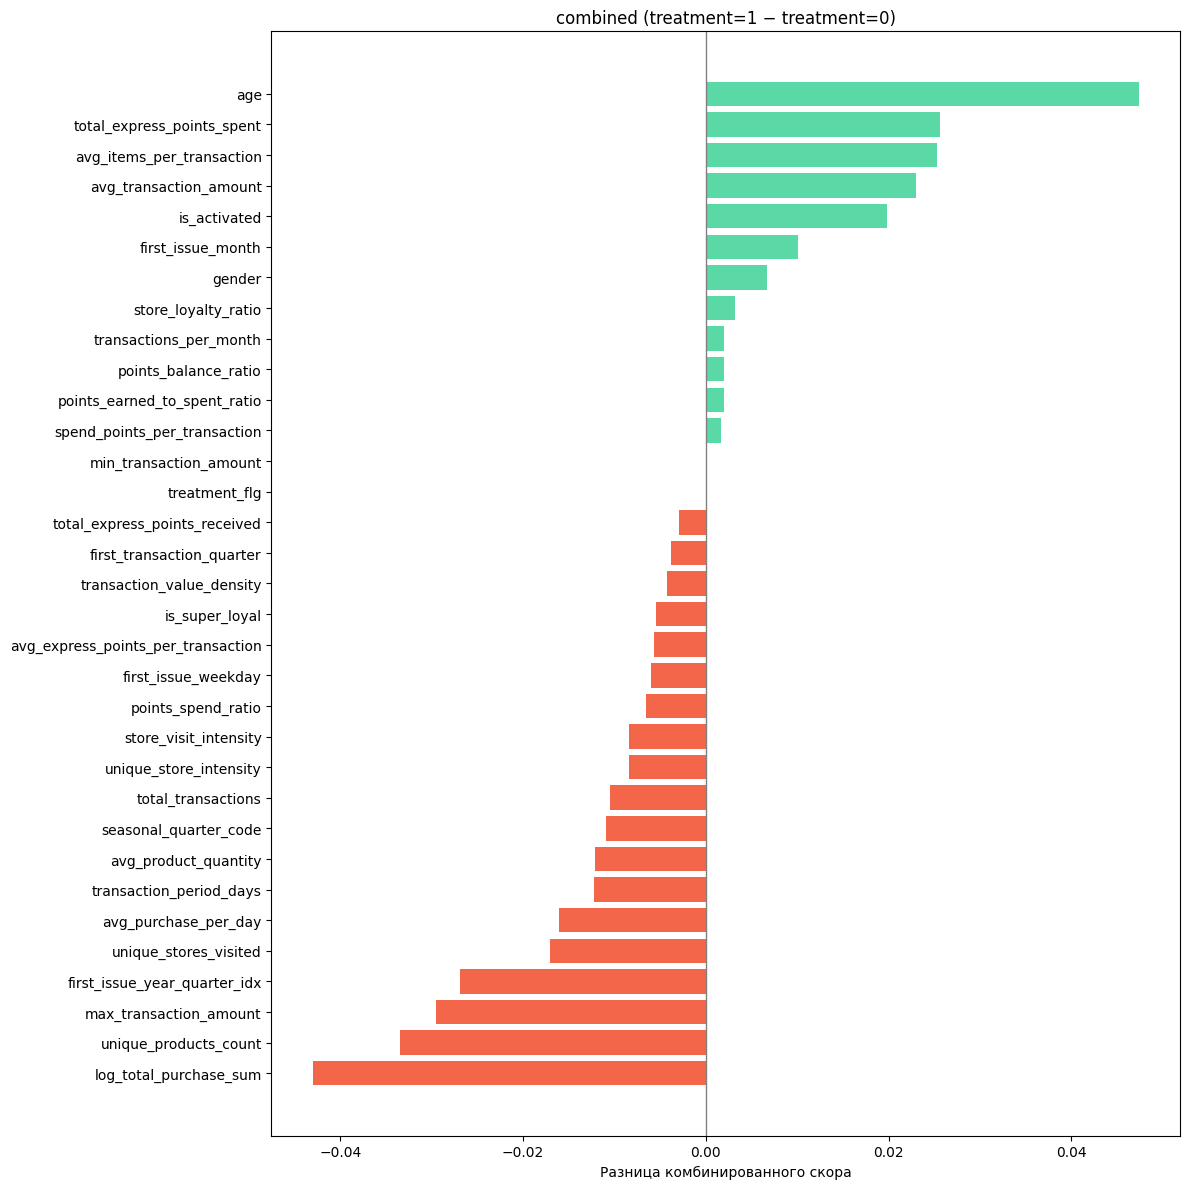

In [34]:
summary_t0 = feature_summary(final_df_for_analysis.query("treatment_flg == 0"), target="target")
summary_t1 = feature_summary(final_df_for_analysis.query("treatment_flg == 1"), target="target")

compare = (
    summary_t0[["feature", "kind", "combined"]]
    .merge(summary_t1[["feature", "combined"]],
           on="feature", suffixes=("_t0", "_t1"))
)

# Разница между treatment=1 и treatment=0
compare["delta"] = compare["combined_t1"] - compare["combined_t0"]
compare = compare.sort_values("delta", ascending=False).reset_index(drop=True)

print("Наиболее усилившиеся признаки (treatment=1 выше):")
display(compare.head(10))

print("Наиболее ослабленные признаки (treatment=1 ниже):")
display(compare.tail(10))


plt.figure(figsize=(12, max(5, 0.4*len(compare.head(30)))))
sub = compare.iloc[::-1]

colors = np.where(sub["delta"] > 0, "#5AD8A6", "#F4664A")

plt.barh(sub["feature"], sub["delta"], color=colors)
plt.axvline(0, color="gray", lw=1)
plt.title("combined (treatment=1 − treatment=0)")
plt.xlabel("Разница комбинированного скора")
plt.tight_layout()
plt.show()


Интерпретация:

Признаки, усилившиеся под воздействием кампании:

- `age` (+0.047) — кампания сработала лучше среди определённых возрастных групп; чувствительность клиентов к воздействию зависит от возраста (возможно, молодые или пожилые реагируют активнее).  
- `total_express_points_spent` и `avg_items_per_transaction` (+0.026) — активно тратящие экспресс-баллы и больше покупающие, сильнее вовлекаются в акцию.   
- `avg_transaction_amount` (+0.023) — вероятно, кампания стимулировала дополнительные траты у среднечековых клиентов.   
- `is_activated` (+0.020) — активированные клиенты лучше реагируют на коммуникацию.  
- `first_issue_month` (+0.010) — отклики чаще среди карт, выпущенных в определённые месяцы (предпологаем, что недавно активированные).  
- `gender` (+0.007) — небольшая, но значимая дифференциация по полу.  
- `store_loyalty_ratio` (+0.003) — чуть сильнее отклик у местных клиентов, лояльных одному магазину.  
- `transactions_per_month` (+0.002) — частота покупок усилила предсказательность, регулярные клиенты реагируют чаще.  
- `points_balance_ratio` (+0.002) — те, у кого баллов много, активнее реагируют на стимул.

Для uplift-модели можно сказать, что у этих признаков информативность возрастает при воздействии.

---

Признаки, ослабленные под воздействием:

- `seasonal_quarter_code` и `total_transactions` (−0.011) — сезонность теряет значимость, значит, акция нивелировала сезонные различия в активности.  
- `avg_product_quantity` (−0.012) — количество товаров в чеке не указывает на промо-эффект.  
- `transaction_period_days` (−0.012) — длительность активности клиента перестала быть фактором отклика, возможно из-за массового охвата.  
- `avg_purchase_per_day` (−0.016) — кампания уравняла паттерны покупок.  
- `unique_stores_visited` (−0.017) — география покупок сама по себе не играет роли: акция одинаково воздействовала в разных точках.  
- `first_issue_year_quarter_idx` (−0.027) — время получения карты не объясняет отклик.   
- `max_transaction_amount` (−0.029) — крупные траты не гарантируют отклика — таргетировался не премиальный сегмент товаров.
- `unique_products_count` (−0.033) — разнообразие ассортимента стало менее важно: кампания подействовала и на стабильных покупателей.   
- `log_total_purchase_sum` (−0.043) — суммарный объём покупок утратил силу: активировались не только крупные клиенты.

Эти признаки стоит ослабить в uplift-модели, т.к. они перестали дифференцировать эффект treatment.

---

Выводы:

- Маркетинговая кампания выровняла активность по большинству традиционных метрик (сумма, чек, корзина, период).  
- Но усилила различия по возрасту, бонусным привычкам, активации и средней частоте покупок.  
- Это указывает на явный поведенческий эффект (в противовес ценовому). 

# Распределение таргета по тритменту

Распределение таргета по тритменту (%):
target               0.0        1.0
treatment_flg                      
0.0            39.671990  60.328010
1.0            36.348906  63.651094

Абсолютные значения:
target           0.0    1.0
treatment_flg              
0.0            39695  60363
1.0            36342  63639


<Figure size 1000x600 with 0 Axes>

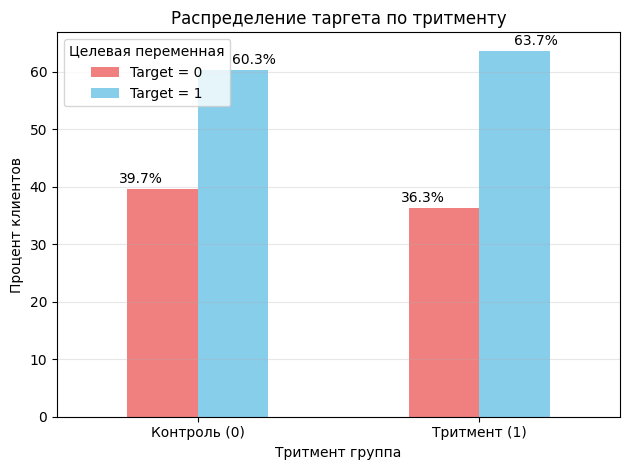

Общий размер выборки: 200039
Размер контрольной группы: 100058
Размер тритмент группы: 99981
Общая конверсия: 0.620
Конверсия в контрольной группе: 0.603
Конверсия в тритмент группе: 0.637


In [35]:
plt.figure(figsize=(10, 6))

target_by_treatment = pd.crosstab(final_df_for_analysis['treatment_flg'], 
                                  final_df_for_analysis['target'], 
                                  normalize='index') * 100

print("Распределение таргета по тритменту (%):")
print(target_by_treatment)
print("\nАбсолютные значения:")
print(pd.crosstab(final_df_for_analysis['treatment_flg'], final_df_for_analysis['target']))

target_by_treatment.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Распределение таргета по тритменту')
plt.xlabel('Тритмент группа')
plt.ylabel('Процент клиентов')
plt.xticks([0, 1], ['Контроль (0)', 'Тритмент (1)'], rotation=0)
plt.legend(['Target = 0', 'Target = 1'], title='Целевая переменная')
plt.grid(axis='y', alpha=0.3)

# подписи с процентами
for i, (idx, row) in enumerate(target_by_treatment.iterrows()):
    plt.text(i - 0.2, row[0] + 1, f'{row[0]:.1f}%', ha='center')
    plt.text(i + 0.2, row[1] + 1, f'{row[1]:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# доп статистика
print(f"Общий размер выборки: {len(final_df_for_analysis)}")
print(f"Размер контрольной группы: {len(final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 0])}")
print(f"Размер тритмент группы: {len(final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 1])}")
print(f"Общая конверсия: {final_df_for_analysis['target'].mean():.3f}")
print(f"Конверсия в контрольной группе: {final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 0]['target'].mean():.3f}")
print(f"Конверсия в тритмент группе: {final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 1]['target'].mean():.3f}")

**Интерпретация распределения target по treatment_flg:**

В контрольной группе (treatment_flg = 0):  60.3% клиентов совершили целевое действие.
В тритмент группе (treatment_flg = 1): 63.7% клиентов совершили целевое действие.

Это значит, доля откликнувшихся увеличилась на 3.32 процентных пункта.

- Положительный uplift по target — кампания работает в среднем: в тритмент группе больше клиентов выполнили целевое действие.  
- Контроль показывает "естественную" конверсию без вмешательства (~60%).  
- Тритмент показывает конверсию под воздействием кампании (~64%).  
- Следовательно, воздействие повышает вероятность целевого действия.
  
Таким образом, в среднем эффект положительный, и можно искать, у кого он особенно силён или слаб, анализируя признаковые отличия.

**Теперь посмотрим статистическую значимость зависимости таргета от тритмента:**

In [36]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint

Тритмент группа: 63639.0 откликов из 99981 (конверсия: 0.637)
Контрольная группа: 60363.0 откликов из 100058 (конверсия: 0.603)

Результаты Z-теста для пропорций:
Z-статистика: 15.3093
P-value: 0.0000

Результаты T-теста:
T-статистика: 15.3182
P-value: 0.0000

95% доверительные интервалы:
Контрольная группа: [0.600, 0.606]
Тритмент группа: [0.634, 0.639]


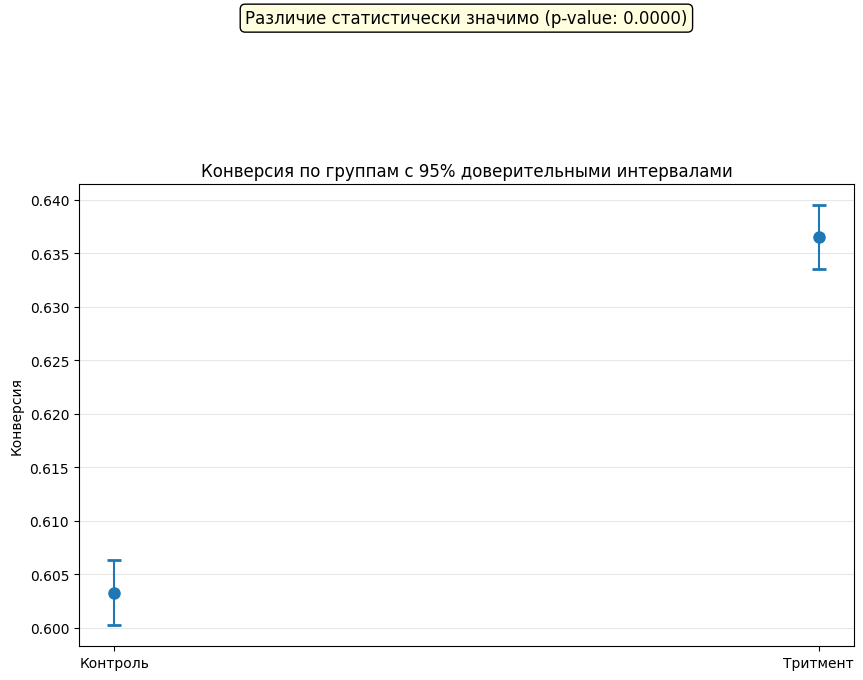


 Результаты:
Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО (p-value = 0.0000)
Uplift эффект: 5.51%
Тритмент увеличивает конверсию на 3.32 процентных пунктов

Уровень значимости: α = 0.05


In [37]:
control_group = final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 0]
treatment_group = final_df_for_analysis[final_df_for_analysis['treatment_flg'] == 1]

successes = [treatment_group['target'].sum(), control_group['target'].sum()]
nobs = [len(treatment_group), len(control_group)]

print(f"Тритмент группа: {successes[0]} откликов из {nobs[0]} (конверсия: {successes[0]/nobs[0]:.3f})")
print(f"Контрольная группа: {successes[1]} откликов из {nobs[1]} (конверсия: {successes[1]/nobs[1]:.3f})")

# Z-тест для пропорций
z_stat, p_value = proportions_ztest(successes, nobs)
print(f"\nРезультаты Z-теста для пропорций:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# T-тест для дополнительной проверки
t_stat, p_value_t = stats.ttest_ind(treatment_group['target'], control_group['target'])
print(f"\nРезультаты T-теста:")
print(f"T-статистика: {t_stat:.4f}")
print(f"P-value: {p_value_t:.4f}")

# расчет доверительных интервалов

conf_int_control = proportion_confint(successes[1], nobs[1], alpha=0.05, method='normal')
conf_int_treatment = proportion_confint(successes[0], nobs[0], alpha=0.05, method='normal')

print(f"\n95% доверительные интервалы:")
print(f"Контрольная группа: [{conf_int_control[0]:.3f}, {conf_int_control[1]:.3f}]")
print(f"Тритмент группа: [{conf_int_treatment[0]:.3f}, {conf_int_treatment[1]:.3f}]")

# визуализация результатов теста
plt.figure(figsize=(10, 6))

# точечная оценка и доверительные интервалы
groups = ['Контроль', 'Тритмент']
means = [successes[1]/nobs[1], successes[0]/nobs[0]]
conf_intervals = [
    [conf_int_control[0], conf_int_control[1]],
    [conf_int_treatment[0], conf_int_treatment[1]]
]

plt.errorbar(groups, means, 
             yerr=[means[0] - conf_intervals[0][0], means[1] - conf_intervals[1][0]], 
             fmt='o', capsize=5, capthick=2, markersize=8)
plt.title('Конверсия по группам с 95% доверительными интервалами')
plt.ylabel('Конверсия')
plt.grid(axis='y', alpha=0.3)

significance = "статистически значимо" if p_value < 0.05 else "не статистически значимо"
plt.text(0.5, max(means) + 0.02, f'Различие {significance} (p-value: {p_value:.4f})', 
         ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

plt.show()

# интерпретация результатов
print("\n Результаты:")
if p_value < 0.05:
    uplift = (means[1] - means[0]) / means[0] * 100
    print(f"Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО (p-value = {p_value:.4f})")
    print(f"Uplift эффект: {uplift:.2f}%")
    print(f"Тритмент увеличивает конверсию на {(means[1] - means[0])*100:.2f} процентных пунктов")
else:
    print(f"Различие между группами НЕ СТАТИСТИЧЕСКИ ЗНАЧИМО (p-value = {p_value:.4f})")
    print("Нет достаточных доказательств влияния тритмента на целевую переменную")

print(f"\nУровень значимости: α = 0.05")

Интерпретация в терминах аплифта:

- Выборка корректна: обе группы примерно равны по объёму, дисбаланса нет.  
- Кампания действительно повышает вероятность целевого действия — не случайность.  
- Средний uplift ≈ +3 п.п. — это экономически значимый эффект: каждый сотый клиент, который раньше бы не купил, теперь совершает покупку.  
- Относительный рост ≈ +5.5 % — сильный результат для маркетинговых акций или программ лояльности.

---

Выводы:

- Кампания доказала эффективность на популяционном уровне.  
- Следующий шаг — искать гетерогенные эффекты: у кого uplift выше (по возрасту, активности, бонусам и т.д.).  
- По факту можно строить uplift-модель, чтобы таргетировать именно тех клиентов, для которых эффект максимален.

# Балансировка контрольной и тритмент групп

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
from scipy.sparse import issparse
from sklift.metrics import qini_auc_score
import pandas as pd, inspect

Проверка баланса и рандомности групп:

---
1. Проверка рандомности назначения (Propensity AUC):
- Обучаем логистическую регрессию T ~ X и считаем ROC AUC.  
- Интерпретация:  
  - AUC ≈ 0.5 — назначение близко к случайному.  
  - AUC > 0.6 — тритмент можно предсказать по признакам, возможно смещение групп.

Цель: убедиться, что treatment не коррелирует с исходными признаками.

---
2. Проверка баланса ковариат (|SMD| и Love-plot):
- Считаем Standardized Mean Difference (SMD) между группами T=0 и T=1 для всех признаков (числовых и категориальных one-hot).  
- Визуализируем на Love-plot: горизонтальные бары по SMD, пороги 0.1 и 0.2.  
- Интерпретация:  
  - SMD ≤ 0.10 — отличный баланс.  
  - SMD ≤ 0.20 — допустимый.  
  - SMD > 0.20 — дисбаланс, стоит скорректировать (через мэтчинг клиентов).  

Цель: убедиться, что группы сравнимы по всем признакам.

---
3. Проверка целевых долей (Sanity-check):
- Сравниваем \( P(Y=1|T=1) \) и \( P(Y=1|T=0) \), считаем z-тест и 95% доверительный интервал.  
- Оценка наличия эффекта.

Цель: убедиться, что данные корректные и эффект (или его отсутствие) реалистичен.

---
Про используемые метрики:

- Propensity AUC — насколько по признакам можно угадать treatment (мера случайности).  
- SMD (Standardized Mean Difference) — стандартизированная разница средних/долей между группами.  
- Love-plot — визуализация SMD для быстрого просмотра баланса по всем фичам.  
- Δ P(Y|T) — sanity-проверка наличия эффекта.  
---

Если Propensity AUC ≈ 0.5 и большинство SMD ≤ 0.1 — выборка сбалансирована, и можно переходить к построению uplift-моделей.

In [39]:
T_COL, Y_COL = "treatment_flg", "target"

# Копия данных для анализа
df = final_df_for_analysis.copy()
#df = df.replace([np.inf, -np.inf], 0)

# Фичи и таргеты
exclude = [T_COL, Y_COL] if Y_COL in df.columns else [T_COL]
X = df.drop(columns=exclude, errors="ignore")
t = df[T_COL].astype(int).values

# Разделяем по типам
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Кодируем категориальные
if len(cat_cols) > 0:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat = pd.DataFrame(
        ohe.fit_transform(X[cat_cols]),
        columns=ohe.get_feature_names_out(cat_cols),
        index=X.index
    )
else:
    X_cat = pd.DataFrame(index=X.index)

# Объединяем и чистим
X_num = X[num_cols].astype(float)
X_full = pd.concat([X_num, X_cat], axis=1)
X_full = X_full.replace([np.inf, -np.inf], 0).fillna(0)

# Стандартизация и логистическая регрессия для вероятностей
scaler = StandardScaler(with_mean=False)
X_scaled = np.nan_to_num(
    scaler.fit_transform(X_full),
    nan=0.0, posinf=0.0, neginf=0.0
)
model = LogisticRegression(max_iter=2000)
model.fit(X_scaled, t)

p_hat = model.predict_proba(X_scaled)[:, 1]
auc_prop = roc_auc_score(t, p_hat)

# SMD
mask0, mask1 = (t == 0), (t == 1)
X_mat = X_scaled.copy()

m0, m1 = X_mat[mask0].mean(axis=0), X_mat[mask1].mean(axis=0)
s0, s1 = X_mat[mask0].std(axis=0, ddof=1), X_mat[mask1].std(axis=0, ddof=1)

pooled = np.sqrt((s0**2 + s1**2) / 2)
smd = np.where(pooled > 0, (m1 - m0) / pooled, np.nan)
abs_smd = np.abs(smd)

feat_names = X_full.columns.tolist()

smd_df = (
    pd.DataFrame({"feature": feat_names, "absSMD": abs_smd})
    .sort_values("absSMD", ascending=False)
    .reset_index(drop=True)
)

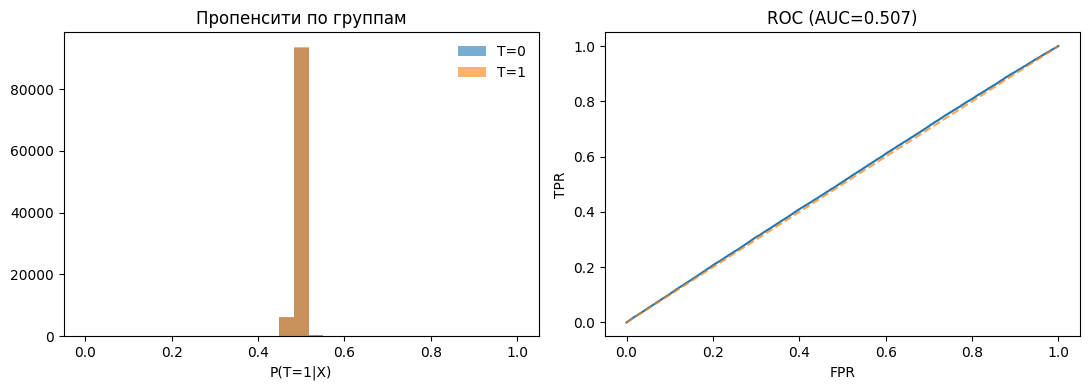

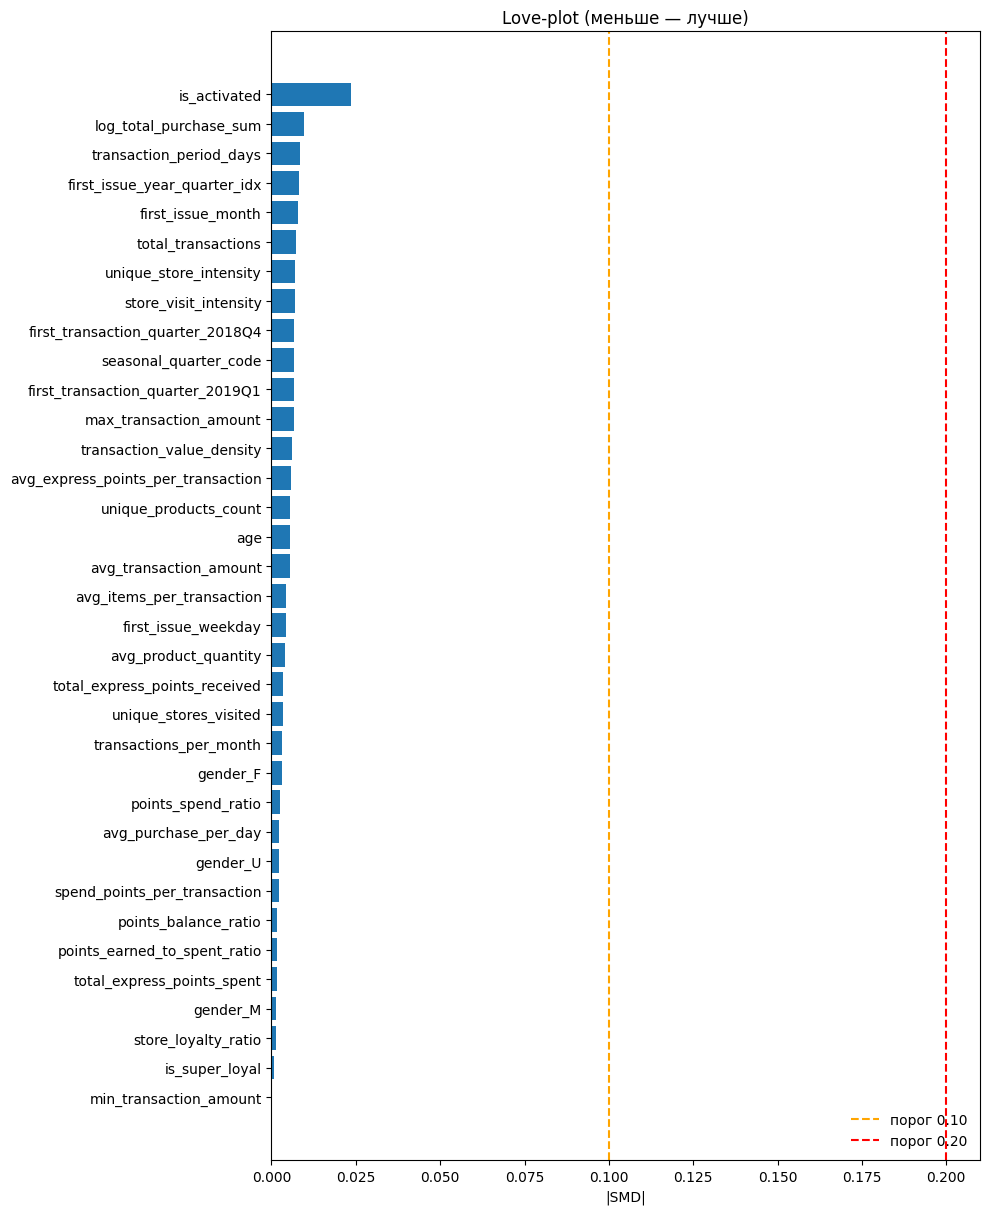

,feature,absSMD
0,is_activated,0.023444
1,log_total_purchase_sum,0.009506
2,transaction_period_days,0.008379
3,first_issue_year_quarter_idx,0.008032
4,first_issue_month,0.007850
5,total_transactions,0.007304
6,unique_store_intensity,0.006842
7,store_visit_intensity,0.006842
8,first_transaction_quarter_2018Q4,0.006790
9,seasonal_quarter_code,0.006790


In [40]:

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
bins = np.linspace(0, 1, 30)
ax[0].hist(p_hat[df[T_COL]==0], bins=bins, alpha=0.6, label="T=0")
ax[0].hist(p_hat[df[T_COL]==1], bins=bins, alpha=0.6, label="T=1")
ax[0].set(title="Пропенсити по группам", xlabel="P(T=1|X)"); ax[0].legend(frameon=False)
fpr, tpr, _ = roc_curve(t, p_hat)
ax[1].plot(fpr, tpr); ax[1].plot([0,1],[0,1],"--",alpha=.7)
ax[1].set(title=f"ROC (AUC={auc_prop:.3f})", xlabel="FPR", ylabel="TPR")
plt.tight_layout(); plt.show()

# Love-plot
top = smd_df.iloc[::-1]
plt.figure(figsize=(10, max(5, 0.35*len(top))))
plt.barh(top["feature"], top["absSMD"])
plt.axvline(0.1, color="orange", linestyle="--", label="порог 0.10")
plt.axvline(0.2, color="red", linestyle="--", label="порог 0.20")
plt.title("Love-plot (меньше — лучше)"); plt.xlabel("|SMD|")
plt.legend(frameon=False, loc="lower right")
plt.tight_layout(); plt.show()

display(smd_df)

Интерпретация:

Все признаки имеют SMD < 0.03 — идеальный баланс (ниже порога 0.1). Контроль и тритмент практически идентичны, рандомизация корректна.

- `is_activated` (0.023) — чуть больше активированных карт, не критичный показатель.  
- `log_total_purchase_sum`, `total_transactions`, `transaction_period_days` — равные по активности группы.  
- `first_issue_month`, `seasonal_quarter_code` — лёгкие сезонные различия без смещения.  
- `store_visit_intensity`, `unique_store_intensity` — равномерное распределение по магазинам.

Вывод: группы сбалансированы, эффект uplift (≈ +3 п.п.) обусловлен кампанией, а не структурными отличиями.

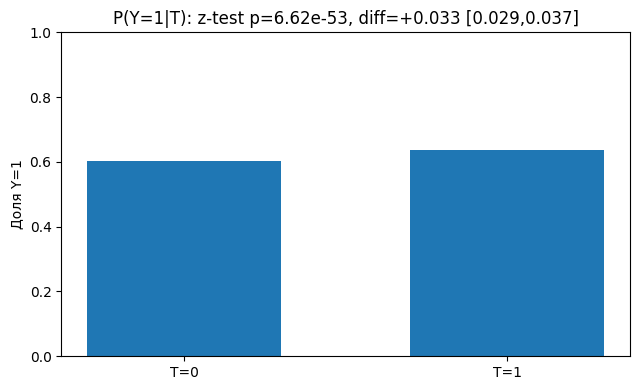

P(Y=1|T=0)=0.603, P(Y=1|T=1)=0.637, diff=+0.033, p=6.62e-53


In [41]:
# 3) Сравнение долей таргета в группах (sanity)
if Y_COL in final_df_for_analysis.columns:
    y = final_df_for_analysis[Y_COL].astype(int).values
    n0, n1 = mask0.sum(), mask1.sum()
    k0, k1 = (y[mask0]==1).sum(), (y[mask1]==1).sum()
    p0, p1 = k0/n0, k1/n1
    stat, pval = proportions_ztest([k1, k0], [n1, n0])
    se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
    z = norm.ppf(0.975); ci = ( (p1-p0) - z*se, (p1-p0) + z*se )

    plt.figure(figsize=(6.5,4))
    plt.bar(["T=0","T=1"], [p0,p1], width=0.6)
    plt.ylabel("Доля Y=1"); plt.ylim(0,1)
    plt.title(f"P(Y=1|T): z-test p={pval:.3g}, diff={p1-p0:+.3f} [{ci[0]:.3f},{ci[1]:.3f}]")
    plt.tight_layout(); plt.show()

    print(f"P(Y=1|T=0)={p0:.3f}, P(Y=1|T=1)={p1:.3f}, diff={p1-p0:+.3f}, p={pval:.3g}")

Интерпретация:

Контроль: P(Y=1|T=0) = 0.603.  
Тритмент: P(Y=1|T=1) = 0.637.  
Разница = +0.033 (≈ +3.3 п.п.).  
p = 6.6 × 10⁻⁵³ значит, что различие статистически значимо, случайность исключена.

Вывод: акция увеличила долю целевого отклика примерно на 3 п.п., эффект устойчивый и подтверждён.

In [42]:
# Qini AUC вокруг нуля — признак отсутствия очевидного uplift на базовых скорах
qini = qini_auc_score(y_true=y, uplift=p_hat, treatment=t)
print(f"Qini AUC на пропенсити-скоре: {qini:.3f}")

Qini AUC на пропенсити-скоре: 0.001


Интерпретация Qini AUC:

Qini AUC = 0.001 — почти ноль, то есть модель пропенсити не способна отличить клиентов тритмента от контроля.  
Значит, рандомизация сработала, группы сформированы случайно, и все последующие различия в целевой переменной будут отражать эффект кампании, а не структурный сдвиг данных.

Общий вывод по EDA:

1. Группы равновесные: ни по возрасту, ни по объёмам покупок, ни по активности нет существенных смещений (SMD < 0.03).  
   Это говорит, что исходное распределение клиентов было честным и репрезентативным.  

2. Тритмент дал статистически значимый прирост: +3.3 п.п. в конверсии (0.637 против 0.603), p ≈ 10⁻⁵³.  
   Разница устойчива и подтверждается по всем тестам (Z, T, sanity).  

3. Ключевые признаки, усилившиеся под воздействием кампании — `is_activated`, `avg_transaction_amount`, `avg_items_per_transaction`.   
   Отражают рост вовлечённости и среднего чека, а не просто частоту покупок.  

4. Qini-показатель подтвердил, что выборка не искажена моделью распределения тритмента.  
   Значит, можно интерпретировать uplift как причинный эффект воздействия.

---
Следующий этап:

- Построить модели uplift.
- Проверить стабильность uplift по сезонам и типам клиентов.  
- Подготовить итоговый сет признаков для обучения и валидации моделей.  

Итого: выборка корректна, uplift реален, данные готовы для следующего шага — моделирования индивидуального эффекта воздействия (и подотовки платформы "умного" таргетирования рекламы).

Стоит заметить, что такие идеальные значения всех тестов могут быть обусловлены выбором данных — X5 готовил их для соревнований по ML-моделям uplift, поэтому данные здесь могут быть изначально сбалансированы.   
Но наша проверка универсально работает и на других данных при условии корректного feature-engeneering (в случае нашей базы мы определяли фичи больше по значимости в контексте ритейла).